Helper Functions

In [13]:
#funtcions
import os
import tarfile
import pandas as pd
import numpy as np
import csv

from statsmodels.tools.tools import add_constant
import math
import matplotlib.pyplot as plt
import seaborn as sns

#helper functions
def find_delimiter(filename):
    sniffer = csv.Sniffer()
    with open(filename) as fp:
        delimiter = sniffer.sniff(fp.read(5000)).delimiter
    return delimiter

#extract gaps function removes gaps for training and testing of the models 
def extractgaps(df):
    dfgaps = df[pd.isna(df['Label'])]
    return dfgaps

#controlls the results from the zero growth model on mistakes of negative growth values. Just to be sure. Wrong values are replaced with 0
def handle_negval_sub(row):
    if (row['Label'] < 0):
        row['Label'] = 0
    return row
def handle_negval(df):
    df.apply(handle_negval_sub, axis=1)
    return df

#check incorrect zero growth values in winter month: when growth is predicted, replace entry with entry before. This is done for DOY < 60 and DOY > 304.
def cleanLabel(df):
    indices = df.index[(df['DOY'] < 60)]
    indices = indices.append(df.index[(df['DOY'] > 304)])
    

    # Loop through each index and replace the corresponding 'Label_DMwth' value
    for index in indices:
        df.loc[index, 'Label'] = df.loc[index - 1, 'Label']
    return df

#libraries
import os
import tarfile
import pandas as pd
import numpy as np
import csv

from statsmodels.tools.tools import add_constant
import math
import matplotlib.pyplot as plt
import seaborn as sns


#reads csv files of any kind of separator 
def create_df_csv(path, short=True):
    """Reads csv file and returns dataframe. 
    KEYWORD ARGUMENTS
    path: str - the path of the file
    short: Boolean - is it a short hobo list or a long continuous list? default = True
    ATTENTION
    """
    # "infer" is default for header
    #check the delimiter    
    delim = find_delimiter(path)
    return pd.read_csv(path, delimiter = delim, header=0 if short else 'infer')


#cleans the data: input is df with columns DOY, Year, Hour, VPD, Label; names must be the one listed here! Returns the new cleaned dataframe and the dataframe including all gaps
def cleanData(df, ZG = False):
    df_gaps = extractgaps(df)
    newdf = handle_negval(df)
    if (ZG == True):
        newdf = cleanLabel(newdf)
    newdf = newdf.dropna()
    return newdf, df_gaps


#train test split
#df = your dataframe consisting of DOY, Year, Hour, VPD, Label
def traintestsplit(df): 
    from sklearn.model_selection import train_test_split
    #split data into X and y (X = DOY,Year;Hour,VPD, y = Label)
    X = df.drop(labels=['Label'], axis=1) 
    y = df['Label']
    X['strat'] = X['Hour'].astype(str) + X['Year'].astype(str)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= X['strat']) #stratified sampling by Hour and Year
    X_train = X_train.drop(columns = ['strat'])
    X_test = X_test.drop(columns = ['strat'])
    return X_train, X_test, y_train, y_test


#scaling of the data
#X_train = X train output from traintestplit() 
#path = path where to save the Scaler, given as character
def ZTransformTrain(X_train, path):

    from sklearn.preprocessing import StandardScaler
    import joblib
    scaler = StandardScaler() 
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    joblib.dump(scaler, path) 
    return X_train_scaled, scaler

#if you want to test the performance differences of best algorithms rf, xgb, knn and ridge. 
def testall4(X_train, X_test, y_train, y_test):
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error 
    from sklearn.metrics import r2_score 
    import xgboost as xgb
    from sklearn import linear_model
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.neighbors import KNeighborsRegressor
    #build evaulation set for xgb
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    #random forest
    rf_reg = RandomForestRegressor(random_state=42)
    rf_reg_model = rf_reg.fit(X_train,y_train)

    Train_pred_rf = rf_reg_model.predict(X_train)
    Train_test_pred_rf = rf_reg_model.predict(X_test)
    performance = pd.DataFrame(columns=['Model','RMSE_train', 'R2_train','RMSE_test', 'R2_test'])
    performance.loc[1] = 'RF', mean_squared_error(y_train, Train_pred_rf, squared=False), round(r2_score(y_train, Train_pred_rf),2),mean_squared_error(y_test, Train_test_pred_rf, squared=False), round(r2_score(y_test, Train_test_pred_rf),2)
    
    #knn
    knn_reg = KNeighborsRegressor()
    knn_reg_model = knn_reg.fit(X_train,y_train)

    Train_pred_knn = knn_reg_model.predict(X_train)
    Train_test_pred_knn = knn_reg_model.predict(X_test)
    performance.loc[2]  = 'kNN', mean_squared_error(y_train, Train_pred_knn, squared=False), round(r2_score(y_train, Train_pred_knn),2),mean_squared_error(y_test, Train_test_pred_knn, squared=False), round(r2_score(y_test, Train_test_pred_knn),2)
    
    #ridge
    ridge_reg = linear_model.Ridge()
    ridge_reg_model = ridge_reg.fit(X_train,y_train)

    Train_pred_ridge = ridge_reg_model.predict(X_train)
    Train_test_pred_ridge = ridge_reg_model.predict(X_test)
    performance.loc[3]  ='Ridge', mean_squared_error(y_train, Train_pred_ridge, squared=False), round(r2_score(y_train, Train_pred_ridge),2),mean_squared_error(y_test, Train_test_pred_ridge, squared=False), round(r2_score(y_test, Train_test_pred_ridge),2)
    
    #xgb
    xgb_reg = xgb.XGBRegressor(early_stopping_round = 10) 
    
    xgb_reg_model = xgb_reg.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose = False)
    Train_pred_xgb = xgb_reg_model.predict(X_train)
    Train_test_pred_xgb = xgb_reg_model.predict(X_test)
   
    performance.loc[4] = 'XGB', mean_squared_error(y_train, Train_pred_xgb, squared=False), round(r2_score(y_train, Train_pred_xgb),2),mean_squared_error(y_test, Train_test_pred_xgb, squared=False), round(r2_score(y_test, Train_test_pred_xgb),2)
    

    return performance
    


#train and test the xgb algorithms to fit it to the training data and check it on the test set. Returns performance, Training set prediction, Test set prediction as dataframes and the final fitted model (xgb_reg_model) 
def testxgb(X_train, X_test, y_train, y_test):
    from sklearn.model_selection import train_test_split
    import xgboost as xgb
    from sklearn.metrics import mean_squared_error 
    from sklearn.metrics import r2_score 
    #build evaulation set for xgb
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
     
    xgb_reg = xgb.XGBRegressor(early_stopping_round = 10) #early stopping prevents the model from overfitting
    xgb_reg_model = xgb_reg.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose = False) #verbose = true enables to see the evaluation runs
    Train_pred_xgb = xgb_reg_model.predict(X_train)
    Train_test_pred_xgb = xgb_reg_model.predict(X_test)
    performance = pd.DataFrame(columns=['Model','RMSE_train', 'R2_train','RMSE_test', 'R2_test'])
    performance.loc[0,:] = 'XGB', mean_squared_error(y_train, Train_pred_xgb, squared=False), round(r2_score(y_train, Train_pred_xgb),2),mean_squared_error(y_test, Train_test_pred_xgb, squared=False), round(r2_score(y_test, Train_test_pred_xgb),2)
    return performance, Train_pred_xgb, Train_test_pred_xgb, xgb_reg_model

Read Data

In [14]:
#read data
example_data = create_df_csv("D:/Seafile/02_Projects/08_Urban_ML/07_Submission/Github_data/example_data_2.csv")

Prepare Data

In [15]:
#clean and find gap data
example_data_cleaned, example_data_gaps = cleanData(example_data)

#split data
example_X_train, example_X_test, example_y_train, example_y_test = traintestsplit(example_data_cleaned)

#scale data
example_X_train_scaled, example_scaler = ZTransformTrain(example_X_train, "D:/Seafile/02_Projects/08_Urban_ML/07_Submission/Github_data/Example_Scaler.bin")

#scale test data on the scaler of the train dataset
example_X_test_scaled = example_scaler.transform(example_X_test)

Fit and test XGB Model

In [16]:
#test different algorithms quickly
#note: rmse results refer to um not mm, divide by 1000 to compare to paper results. 

Example_performances_differentalgos = testall4(X_train=example_X_train_scaled, X_test= example_X_test_scaled, y_train=example_y_train,y_test= example_y_test)

#xgb model setup 
example_performance, example_Train_pred, example_Test_pred, gxb_model = testxgb(X_train=example_X_train_scaled, X_test= example_X_test_scaled, y_train=example_y_train,y_test= example_y_test)

d:\99_Software\Anaconda\envs\NEWEileen\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\99_Software\Anaconda\envs\NEWEileen\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\99_Software\Anaconda\envs\NEWEileen\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\99_Software\Anaconda\envs\NEWEileen\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in

Prepare and predict gaps

In [17]:
#drop Label columns
example_data_gaps = example_data_gaps.drop(columns=['Label'])

In [18]:
#scale to train set 

example_data_gaps_scaled = example_scaler.transform(example_data_gaps)

In [19]:
#predict

Gap_predictions = gxb_model.predict(example_data_gaps_scaled)

In [20]:
#merge
example_gaps_filled = example_data_gaps
example_gaps_filled['Label'] = Gap_predictions

In [21]:
#rearrage gap filled values in dataset

example_final = pd.concat((example_data_cleaned, example_gaps_filled), axis = 0)#merge files
example_final = example_final.sort_index()#sort index

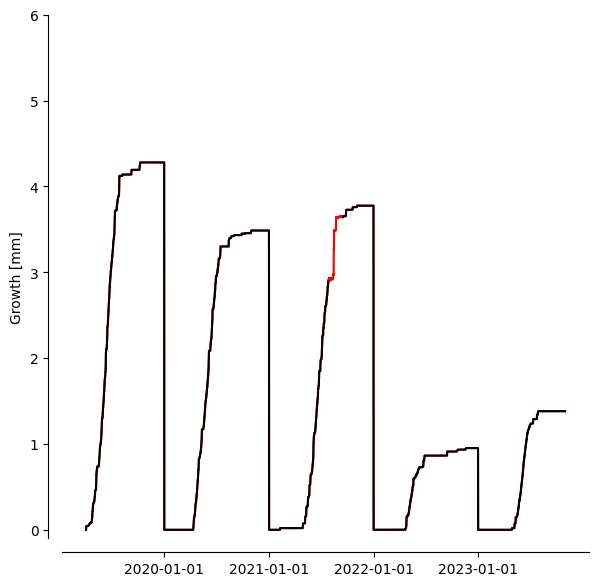

In [22]:
import matplotlib
from sklearn.metrics import mean_squared_error 
matplotlib.rcParams['pdf.fonttype'] = 42 
fig, ax1 = plt.subplots(1,1,figsize=(6.8, 6.8))

date_rng = pd.date_range(start='2019-04-03', end='2023-10-31 23:00:00', freq='h')
month_starts = pd.date_range(start=date_rng.min(), end=date_rng.max(), freq='YS')


ax1.plot(date_rng, example_final['Label']/1000, label='S23_pred', color = "red")  # Plot colUNn B
ax1.plot(date_rng, example_data['Label']/1000, color = "black")  # Plot colUNn A
ax1.set_ylabel('Growth [mm]')
ax1.set_ylim(-0.1,6)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_position(('outward', 10))  # Move x-axis outward by 10 points
ax1.spines['left'].set_position(('outward', 10)) 
ax1.set_xticks(month_starts)

plt.show()

#if you want to save your figure, this is how you can, you need to disable plt.show() for this to work with a #
#plt.savefig("D:/Seafile/02_Projects/08_Urban_ML/05_Figures/Supp/Prediction_on_long_gap.pdf")